In [98]:
from lib.utilities import *
import matplotlib.pyplot as plt

%matplotlib widget

In [99]:
############### User Configuration ###############
##################################################

datadir = "." # All ZDA files in this directory + subdirectories are loaded
selected_filename = "06_01_01" # focus for subsequent analysis
file_type = '.zda'
# Spatial area to investigate
#y_range = [45,-2] 
#x_range = [0,-2] 

# Temporal area to investigate
points_to_skip = 30
time_window = [points_to_skip,-1]  # zda file has a big spike at t=15
measure_window = [90 - points_to_skip, 120 - points_to_skip]

In [100]:
############## Driver script: begin ##############
##################################################

# Load data
processed = [] # to avoid re-processing later
data_loader = DataLoader()
if file_type == '.tsm':
    data_loader.load_all_tsm(data_dir=datadir + "/tsm_targets")
else:
    data_loader.load_all_zda(data_dir=datadir + "/zda_targets")


.\zda_targets/06_01_01.zda


In [101]:
# Select data of interest        
selected_data = data_loader.select_data_by_keyword(selected_filename)

# Clip to the time range 20 ms onward to get rid of the camera "foot"
selected_data.clip_data(t_range=time_window)
#selected_data.bin_data(binning=3)

raw_data, meta, rli = selected_data.get_data(), selected_data.get_meta(), selected_data.get_rli()

{'version': 5, 'slice_number': 6, 'location_number': 1, 'record_number': 1, 'camera_program': 7, 'number_of_trials': 5, 'interval_between_trials': 20, 'acquisition_gain': 1, 'points_per_trace': 969, 'time_RecControl': b'*e\xea^\x00\x00\x00\x00', 'reset_onset': 0.0, 'reset_duration': 100.0, 'shutter_onset': 0.0, 'shutter_duration': 1210.0, 'stimulation1_onset': 100.0, 'stimulation1_duration': 1.0, 'stimulation2_onset': 300.0, 'stimulation2_duration': 1.0, 'acquisition_onset': 50.0, 'interval_between_samples': 0.5, 'raw_width': 999, 'raw_height': 999} (5, 969, 79, 79)


(5, 969, 79, 79)


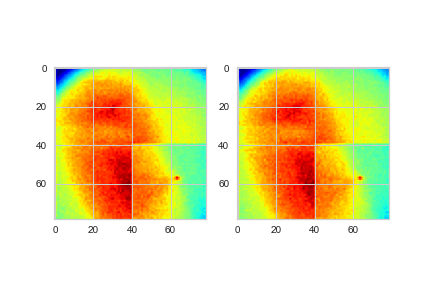

In [102]:
# view frames
fig, axes = plt.subplots(1, 2)
print(raw_data.shape)
axes[0].imshow(raw_data[0,0,:,:],cmap='jet')
axes[1].imshow(raw_data[0,-1,:,:],cmap='jet')
plt.show()

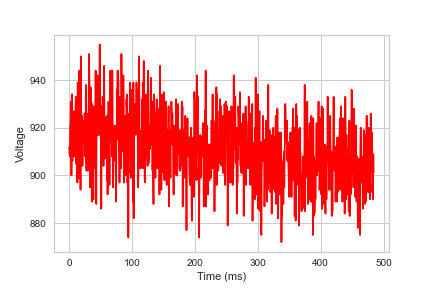

In [103]:
# view a trace
tr = Tracer()
tr.plot_trace(raw_data, 10, 10, meta['interval_between_samples'], trial=0)

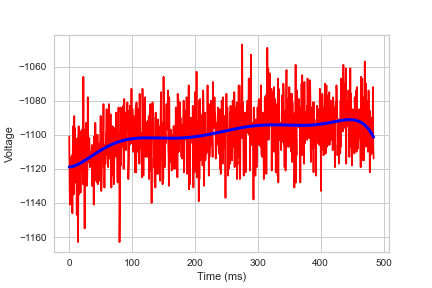

In [104]:
# Run this cell at most once per ZDA load

#data inversing
raw_data = -raw_data

# Need to subtract off the low-frequency voltage drift. First-order correction
tr.correct_background(meta, raw_data)


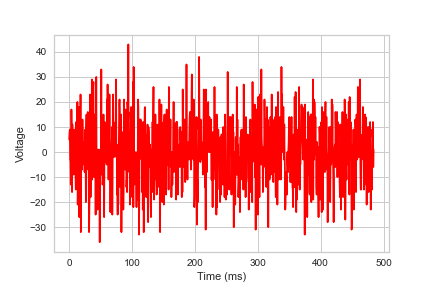

(5, 969, 79, 79)


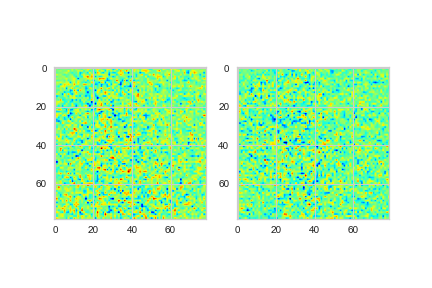

In [105]:

#full trace
tr.plot_trace(raw_data[:,:,:,:], 
           10, 
           10, 
           meta['interval_between_samples'], 
           trial=0)

# view frames
fig, axes = plt.subplots(1, 2)
print(raw_data.shape)
axes[0].imshow(raw_data[0,0,:,:],cmap='jet')
axes[1].imshow(raw_data[0,-1,:,:],cmap='jet')
plt.show()

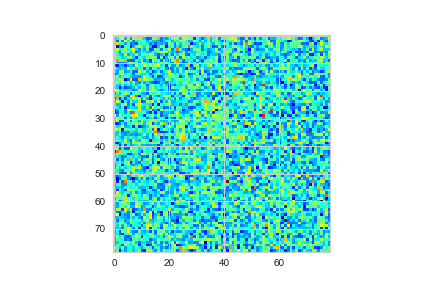

max SNR before: 4.197519016655397 min SNR before: 0.8530948422974156


C:\Users\jjudge3\Desktop\scratch\ZDA_Explorer\lib\snr.py:24: RuntimeWarning: divide by zero encountered in true_divide
  self.snr = np.max(data, axis=0) / np.std(data, axis=0)
C:\Users\jjudge3\Desktop\scratch\ZDA_Explorer\lib\snr.py:24: RuntimeWarning: invalid value encountered in true_divide
  self.snr = np.max(data, axis=0) / np.std(data, axis=0)


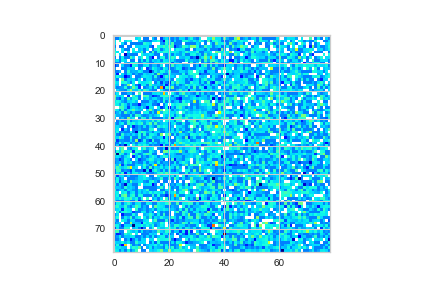

max SNR: nan min SNR: nan


In [106]:
# Examine SNR before and after t-filter
sp = SignalProcessor()
filtered_data = sp.filter_temporal(meta, raw_data, sigma_t=10.0)

trial = filtered_data[0, :, :, :] 
trials = filtered_data

trial_before = raw_data[0, :, :, :] 

asnr_before = AnalyzerSNR(trial_before)
snr_before = asnr_before.get_snr(plot=True, window=measure_window)
print("max SNR before:", np.max(snr_before), "min SNR before:", np.min(snr_before))

asnr = AnalyzerSNR(trial)
snr = asnr.get_snr(plot=True, window=measure_window)
print("max SNR:", np.max(snr), "min SNR:", np.min(snr))


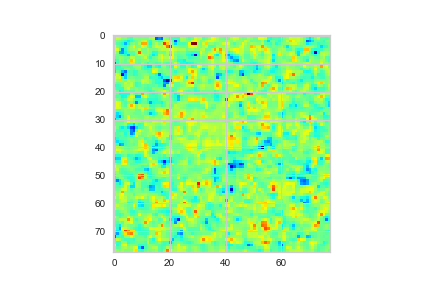

max SNR: 11.670106380193644 min SNR: -7.839141629946991


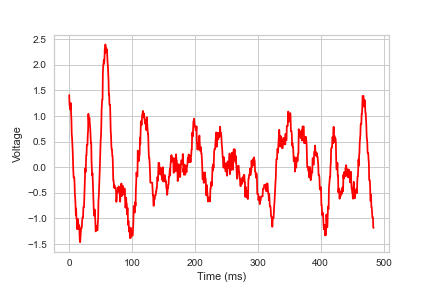

In [107]:
# spatial filtering
filtered_data = sp.filter_spatial(meta, filtered_data)


asnr = AnalyzerSNR(filtered_data[0, :, 1:, 1:])
snr = asnr.get_snr(plot=True, window=measure_window)
print("max SNR:", np.max(snr), "min SNR:", np.min(snr))



tr.plot_trace(filtered_data[:,:,:,:],
           28, 
           28,
           meta['interval_between_samples'], 
           trial=0)

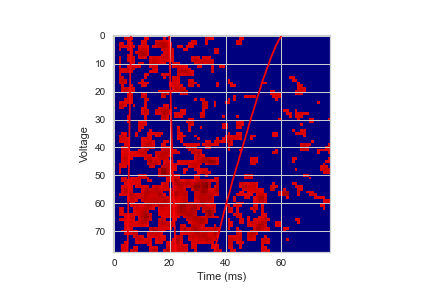

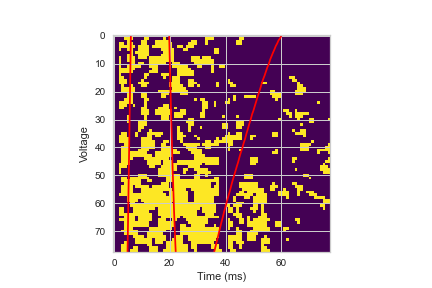

"\nsnr_percentile_cutoff = 0.7\nk_clusters = 3\nsnr_cutoff = np.percentile(snr, snr_percentile_cutoff * 100)\n\nmask = (snr >= snr_cutoff).astype(np.float)\n\n# masked image: reasonability check\nplt.imshow(snr * mask, cmap='jet', interpolation='nearest')\nplt.show()\n\n# 1-D K-means clustering of SNR groups\nkm = KMeans(n_clusters=k_clusters+1).fit(snr.reshape(-1,1)) # +1 for the masked 0's\n\nclustered = np.array(km.labels_).reshape(snr.shape) + 1\nclustered = clustered.astype(np.float)\n\nplt.imshow(clustered * mask, cmap='viridis', interpolation='nearest')\nplt.show()\n"

In [76]:
# impose snr cutoff

asnr.cluster_on_snr(plot=True)
"""
snr_percentile_cutoff = 0.7
k_clusters = 3
snr_cutoff = np.percentile(snr, snr_percentile_cutoff * 100)

mask = (snr >= snr_cutoff).astype(np.float)

# masked image: reasonability check
plt.imshow(snr * mask, cmap='jet', interpolation='nearest')
plt.show()

# 1-D K-means clustering of SNR groups
km = KMeans(n_clusters=k_clusters+1).fit(snr.reshape(-1,1)) # +1 for the masked 0's

clustered = np.array(km.labels_).reshape(snr.shape) + 1
clustered = clustered.astype(np.float)

plt.imshow(clustered * mask, cmap='viridis', interpolation='nearest')
plt.show()
"""

In [77]:
# SNR by cluster
avg_snr_by_cluster = [np.average(snr[np.where(clustered==i)[0]]) for  i in range(1, k_clusters+2)]
print(avg_snr_by_cluster)

cluster_indices_by_snr = np.argsort(np.array(avg_snr_by_cluster)) + 1
highest_snr_cluster = cluster_indices_by_snr[-1]
print(cluster_indices_by_snr)
print("highest_snr_cluster =", highest_snr_cluster)

NameError: name 'k_clusters' is not defined

In [ ]:
# Examine some higher-SNR pixels
n_samples = 5
mask = (snr >= snr_cutoff).astype(np.float)

# Select the pixels in the highest SNR cluster, above SNR cutoff
argmaxes =  np.where(clustered * mask == highest_snr_cluster)
max_samples = argmaxes[0].shape[0]
for i in range(0, max_samples, int(max_samples / n_samples) ):

    x_max = argmaxes[0][i]
    y_max = argmaxes[1][i]
    print("Pixel at (" + str(x_max), ",", str(y_max) + ")")
    plot_trace(trials[:,:,:,time_window[0]:time_window[1]], 
               x_max, 
               y_max, 
               meta['interval_between_samples'], 
               trial=0)

    mask[x_max, y_max] *= 5 # highlight

plt.imshow(clustered * mask, cmap='jet', interpolation='nearest')
plt.show()


In [ ]:
# Spike sorting on the template-matched images

# We are looking for two patterns of shapes:
#   1) sub-threshold ESPSs 
#         - lower amplitude
#         - wider half-width
#   2) spikes
#         - higher amplitude
#         - narrow half-width

k_2d_clusters = 4 # choose via silhouette coefficient

trial = filtered_data[0, x_range[0]:x_range[1], 
                    y_range[0]:y_range[1], :] 
trials = filtered_data[:, x_range[0]:x_range[1], 
                     y_range[0]:y_range[1], :] 

# Let's do 1-D clustering by max amplitude
#   looking, for now, only in the time frame near stim and highest-SNR cluster

# Select the pixels in the highest SNR cluster, above SNR cutoff
px_selector = np.zeros(clustered.shape)
clusters_selected = cluster_indices_by_snr[-2:]
for c in clusters_selected:
    px_selector += (clustered * mask == c)

argmaxes =  np.where(px_selector > 0)
features = np.zeros((argmaxes[0].shape[0], 3))  # (max amp, half-width, cluster index)
i_filled = 0
for i in range(argmaxes[0].shape[0]):

    x_max = argmaxes[0][i]
    y_max = argmaxes[1][i]

    window = trial[x_max,
                   y_max,
                   time_window[0]:time_window[1]]


    # Calculate width at half-max, assuming min is zero 
    #   (valid assumption due to our fitted lin/exp correction)
    hm = features[i,0] / 2.0
    arg_max = np.argmax(window)

    fwhm = get_half_width(arg_max, window)

    # invalid spike, do not store
    if fwhm is None:
        continue
    
    features[i_filled,0] = np.max(window)
    features[i_filled,1] = fwhm
    features[i_filled,2] = clustered[x_max, y_max]
    i_filled += 1

    print("Pixel at (" + str(x_max), 
          ",", 
          str(y_max) + ")\n\t max amplitude:", 
          features[i,0], 
          "at:",
          arg_max,
          "\n\t half width:", 
          features[i,1])
    #plot_trace(trial[:,:,time_window[0]:time_window[1]],
    #           x_max,
    #           y_max,
    #           meta['interval_between_samples'] )

features = features[:i_filled+1, :]

# 2-D K-means clustering on features (max amp, half width)
label = KMeans(n_clusters=k_2d_clusters).fit_predict(features)

for i in range(k_2d_clusters):
    filtered_label = features[label == i]

    plt.scatter(filtered_label[:,0] , filtered_label[:,1])

plt.title("Cluster on (Peak Amplitude, FWHM)")
plt.ylabel("Spike Width at Half Maximum")
plt.xlabel("Spike Max Amplitude")
plt.show()

# plot by SNR cluster
for c in clusters_selected:
    filtered_label = features[features[:, 2] == c]

    plt.scatter(filtered_label[:,0] , filtered_label[:,1])

plt.title("Plotted by SNR cluster")
plt.ylabel("Spike Width at Half Maximum")
plt.xlabel("Spike Max Amplitude")
plt.show()


In [ ]:
# Silhouette analysis

print("Silhouette score:", silhouette_score(features, label))

# Instantiate a scikit-learn K-Means model
model = KMeans(random_state=0)

# Instantiate the KElbowVisualizer with the number of clusters and the metric 
visualizer = KElbowVisualizer(model, k=(2,6), metric='silhouette', timings=False)

# Fit the data and visualize
visualizer.fit(features)    
visualizer.poof()   